In [33]:
import time
import numpy as np
import cv2
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import signal
import os, errno
import glob

In [2]:
## get first and last centroids to 1) Draw tracks 2) do calculate radial distance from flower center

In [3]:
Centroidfiles_direc = r'G:\My Drive\Mahad\Light Level Experiments\Data Output from Analysis/motionAnalysis_v4/Centroids_Relevant_v4/'
centroid_files = glob.glob(Centroidfiles_direc + 'L*.csv')

In [4]:
treatments = ['L0.1' , 'L50']
visits = ['first', 'last']

In [5]:
for v in visits:
    relevantfiles = [f for f in centroid_files if v in f]
    for l in treatments:
        subsetFiles = [f for f in relevantfiles if 'L' + l in f]
        print('number of moths in %s and %s is %d' %(v, l, len(subsetFiles)))

number of moths in first and L0.1 is 0
number of moths in first and L50 is 0
number of moths in last and L0.1 is 0
number of moths in last and L50 is 0


In [6]:
df = pd.DataFrame(data = None, columns = ['lightLevel', 'visitNum', 'flower', 'mothID', 'x', 'y'])

lux = []
flower = []
moth = []
visitNum = []
centroids_x = []
centroids_y = []

for f in centroid_files:
    
    cent = pd.read_csv(f)
    x_pos = cent.X_position
    y_pos = cent.Y_position
    
    n = len(x_pos)
    l, c, m, v = os.path.basename(f).split('_')
    padded_l = [l]*n
    padded_c = [c]*n
    padded_m = [m]*n
    padded_v = [v]*n
    
    lux.extend(padded_l)
    flower.extend(padded_c)
    moth.extend(padded_m)
    visitNum.extend(padded_v)
    centroids_x.extend(x_pos)
    centroids_y.extend(y_pos)

df = pd.DataFrame({'lightLevel': lux
                   , 'visitNum': visitNum
                   , 'flower' : flower
                   , 'mothID': moth
                   , 'x': centroids_x
                   , 'y': centroids_y
                  })

df['visitNum'] = df['visitNum'].replace({'lastVisit.csv':'last', 'firstVisit.csv':'first'})

In [7]:
for v, subdf in df.groupby('visitNum'):
    for l, subsubdf in subdf.groupby('lightLevel'):
        totalMoths = subsubdf.mothID.unique()
        print('number of moths in %s and %s is %d' %(v, l, len(totalMoths)))

number of moths in first and L0.1 is 29
number of moths in first and L50 is 26
number of moths in last and L0.1 is 29
number of moths in last and L50 is 26


In [8]:
df.head()

,lightLevel,visitNum,flower,mothID,x,y
0,L50,first,c-3,m9,NaN,NaN
1,L50,first,c-3,m9,NaN,NaN
2,L50,first,c-3,m9,NaN,NaN
3,L50,first,c-3,m9,3.108108,14.256757
4,L50,first,c-3,m9,9.222973,15.236486


In [9]:
# add the distance measurement to all points

In [10]:
circ_parameters = pd.read_csv('G:\My Drive\Mahad\Light Level Experiments\Data Output from Analysis\motionAnalysis_v3\circle_parameters.csv')
circ_parameters.head()

,Unnamed: 0,name,circ_x,circ_y,circ_radii
0,0,L0.1_c-3_m27,311,233,74
1,1,L0.1_c-3_m25,309,232,74
2,2,L0.1_c-3_m24,310,233,74
3,3,L0.1_c-3_m23,310,233,74
4,4,L0.1_c-3_m22,310,232,74


In [11]:
df['name'] = df['lightLevel'] + '_' + df['flower'] + '_' + df['mothID']
df["flower_x"] = np.nan
df["flower_y"] = np.nan

In [12]:
for n,subdf in df.groupby('name'):
    r = circ_parameters.loc[circ_parameters.name == n, 'circ_radii'].values
    circ_x =  circ_parameters.loc[circ_parameters.name == n, 'circ_x'].values*2.5/r
    circ_y =  circ_parameters.loc[circ_parameters.name == n, 'circ_y'].values*2.5/r
    
    l = len(subdf)
    f_x = [circ_x]*l
    f_y = [circ_y]*l
    
    df.loc[df.name == n, 'flower_x'] = f_x
    df.loc[df.name == n, 'flower_y'] = f_y
#     df['f_x'] = circ_parameters.loc[circ_parameters.name == df['name'], 'circ_x']

In [13]:
df.head()

,lightLevel,visitNum,flower,mothID,x,y,name,flower_x,flower_y
0,L50,first,c-3,m9,NaN,NaN,L50_c-3_m9,10.472973,7.871622
1,L50,first,c-3,m9,NaN,NaN,L50_c-3_m9,10.472973,7.871622
2,L50,first,c-3,m9,NaN,NaN,L50_c-3_m9,10.472973,7.871622
3,L50,first,c-3,m9,3.108108,14.256757,L50_c-3_m9,10.472973,7.871622
4,L50,first,c-3,m9,9.222973,15.236486,L50_c-3_m9,10.472973,7.871622


In [14]:
df['cent_x'] = df['flower_x'] - df['x']
df['cent_y'] = df['flower_y'] - df['y']

In [15]:
df['distance'] = df.loc[:,['cent_x', 'cent_y']].apply(np.linalg.norm, axis=1, ord = 2)

In [16]:
df.head()

,lightLevel,visitNum,flower,mothID,x,y,name,flower_x,flower_y,cent_x,cent_y,distance
0,L50,first,c-3,m9,NaN,NaN,L50_c-3_m9,10.472973,7.871622,NaN,NaN,NaN
1,L50,first,c-3,m9,NaN,NaN,L50_c-3_m9,10.472973,7.871622,NaN,NaN,NaN
2,L50,first,c-3,m9,NaN,NaN,L50_c-3_m9,10.472973,7.871622,NaN,NaN,NaN
3,L50,first,c-3,m9,3.108108,14.256757,L50_c-3_m9,10.472973,7.871622,7.364865,-6.385135,9.747368
4,L50,first,c-3,m9,9.222973,15.236486,L50_c-3_m9,10.472973,7.871622,1.250000,-7.364865,7.470190


In [17]:
df.to_csv('./dataFolders/Output/KinematicAnalysis_v5/CentroidAndDistanceData.csv')

## compute paramters and draw plots

In [18]:
# remove Problematic Files

listProbs = pd.read_csv(r'G:\My Drive\Mahad\Light Level Experiments\Data Output from Analysis\VideosWithMarkers\FirstLastTroubleVideos_v4\names.csv')
listProbs['name'] = listProbs['name'].str[1:]
listProbs.head()

# df.name.str.contains(df.name + '_' + df.visitNum)

,Unnamed: 0,name
0,0,L0.1_c-3_m10_firstVisit.csv
1,1,L0.1_c-3_m10_lastVisit.csv
2,2,L0.1_c-3_m12_firstVisit.csv
3,3,L0.1_c-3_m12_lastVisit.csv
4,4,L0.1_c-3_m23_lastVisit.csv


In [19]:
df['string'] = df.name + '_' + df.visitNum + 'Visit.csv'

sub_df= df[pd.DataFrame(df.string.tolist()).isin(listProbs.name.tolist()).any(1) == False]

In [20]:
sub_df.head()

,lightLevel,visitNum,flower,mothID,x,y,name,flower_x,flower_y,cent_x,cent_y,distance,string
1843,L50,first,c-3,m49,0.608974,14.967949,L50_c-3_m49,9.679487,6.923077,9.070513,-8.044872,12.124115,L50_c-3_m49_firstVisit.csv
1844,L50,first,c-3,m49,NaN,NaN,L50_c-3_m49,9.679487,6.923077,NaN,NaN,NaN,L50_c-3_m49_firstVisit.csv
1845,L50,first,c-3,m49,NaN,NaN,L50_c-3_m49,9.679487,6.923077,NaN,NaN,NaN,L50_c-3_m49_firstVisit.csv
1846,L50,first,c-3,m49,NaN,NaN,L50_c-3_m49,9.679487,6.923077,NaN,NaN,NaN,L50_c-3_m49_firstVisit.csv
1847,L50,first,c-3,m49,1.057692,14.711538,L50_c-3_m49,9.679487,6.923077,8.621795,-7.788462,11.618756,L50_c-3_m49_firstVisit.csv


In [21]:
len(df.string.unique()), len(sub_df.string.unique())

(110, 75)

In [22]:
len(listProbs.name.values)

35

In [23]:
colorScheme = {'L0.1':plt.cm.Purples_r, 'L50':plt.cm.Oranges_r}

In [24]:
def slicePandas(df, lightLevel, visitNum):
    subdf = df[df.visitNum == visitNum]
    subsubdf = subdf[subdf.lightLevel == lightLevel]
    return(subsubdf)

In [25]:
def addAllHist(df):
    h = np.zeros((50,50))
    
    for m, test in df.groupby('mothID'):
        x = test.loc[test.x.notna(), 'x'] 
        y = test.loc[test.y.notna(), 'y']

        heatmap, xedges, yedges = np.histogram2d(x, y, bins = 50)
        heatmap = heatmap/heatmap.max()
        h = h + heatmap
    return(h)

In [26]:
def plotHist(heatmap, cmap, ax):
    
    cmap.set_under(color='black')
    im = ax.imshow(heatmap/heatmap.max()
                 ,  extent = [0, 648, 488, 0]
                 , origin = 'upper'
                 , cmap = cmap
                 , vmin = 0.1)
    ax.axis('off')
    # ax[ii].set_title(v + '_' + l)
#     clr = plt.colorbar(im)

In [27]:
new_df = slicePandas(sub_df, 'L0.1', 'first')
low_first = addAllHist(new_df)

new_df = slicePandas(sub_df, 'L0.1', 'last')
low_last = addAllHist(new_df)

new_df = slicePandas(sub_df, 'L50', 'first')
high_first = addAllHist(new_df)

new_df = slicePandas(sub_df, 'L50', 'last')
high_last = addAllHist(new_df)

allhist = [low_first, low_last, high_first, high_last]

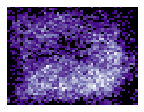

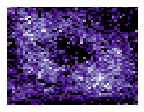

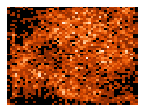

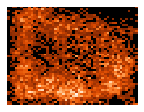

In [127]:
## plot the histograms and save the figures
w = 7/3 
h = w

ii = 0
vv = 0
for listHist in allhist:
    if ii == 0 or ii == 1:
        cmap = colorScheme['L0.1']
        if vv == 0:
            name = 'low_first'
        else: 
            name = 'low_last'
    else:
        cmap = colorScheme['L50']
        if vv == 2:
            name = 'high_first'
        else:
            name = 'high_last'

    
    f, ax = plt.subplots(figsize = (w,h))
    plotHist(listHist, cmap, ax)
    plt.savefig('./dataFolders/Output/KinematicAnalysis_v5/Figures/' + 'heatmap_' + name + '.pdf')
    ii+=1
    vv+=1

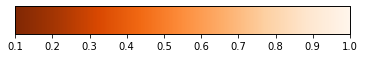

In [125]:
# cmap = plt.cm.Purples_r
# cmap.set_under(color='black')
figname = ['low', 'high']
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

norm = mpl.colors.Normalize(vmin=0.1, vmax=1)

for i, c in enumerate(colorScheme):
#     print(c)
    cmap = colorScheme[c]
    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                    norm = norm,
                                    orientation='horizontal')
    plt.savefig('./dataFolders/Output/KinematicAnalysis_v5/Figures/' + figname[i] + '_colorbar.pdf')

In [48]:
# plot individual moth histrogram and see why is first visit looking like a big glob!

for moth, sub in df.groupby('name'):
    for v, specific in sub.groupby('visitNum'):
        f, ax = plt.subplots()
        x = specific.loc[specific.x.notna(), 'x'] 
        y = specific.loc[specific.y.notna(), 'y']

        heatmap, xedges, yedges = np.histogram2d(x, y, bins = 50)
        heatmap = heatmap/heatmap.max()

        if 'L50' in moth:
            cmap = colorScheme['L50']
        else:
            cmap = colorScheme['L0.1']

        cmap.set_under(color='black')

        im = ax.imshow(heatmap/heatmap.max()
                     ,  extent = [0, 648, 488, 0]
                     , origin = 'upper'
                     , cmap = cmap
                     , vmin = 0.01)
        ax.axis('off')

        f.colorbar(im, ax = ax)
    #     cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
    #                                 orientation='vertical')

        plt.savefig('./dataFolders/Output/KinematicAnalysis_v5/Figures/IndividualMoths/' + moth + '_' + v + '_heatmap.pdf')
        plt.close(f)

In [49]:
listProbs[listProbs.name.str.contains('first') & listProbs.name.str.contains('L0.1')]

,Unnamed: 0,name
0,0,L0.1_c-3_m10_firstVisit.csv
2,2,L0.1_c-3_m12_firstVisit.csv
7,7,L0.1_c-3_m45_firstVisit.csv
9,9,L0.1_c-3_m47_firstVisit.csv
11,11,L0.1_c-3_m50_firstVisit.csv
13,13,L0.1_c-3_m54_firstVisit.csv
14,14,L0.1_c-3_m57_firstVisit.csv
16,16,L0.1_c-3_m5_firstVisit.csv


In [114]:
# plot distance from flower center
# get average distance for each moth
# dataFrame = mothID, first, last, low, high

Dist_df = pd.DataFrame(data = None, columns = ['mothID', 'visit', 'lightLevel', 'distance'])
i = 0
for v, sub in sub_df.groupby('visitNum'):
    for tt, specific in sub.groupby('lightLevel'):
        for moth, final in specific.groupby('mothID'):
            mean_dist = final.distance.median()
            Dist_df.loc[i,'distance'] = mean_dist
            Dist_df.loc[i, 'mothID'] = moth
            Dist_df.loc[i, 'lightLevel'] = tt
            Dist_df.loc[i, 'visit'] = v
            i+=1   

In [115]:
Dist_df.head()

,mothID,visit,lightLevel,distance
0,m2,first,L0.1,5.34243
1,m20,first,L0.1,5.45428
2,m21,first,L0.1,5.88808
3,m22,first,L0.1,7.89471
4,m23,first,L0.1,8.83754


In [116]:
Dist_df['distance']=Dist_df['distance'].astype('float64')

In [132]:
sns.set(style="ticks")
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 8

w = 7/3
# w = 8
h = w * 2

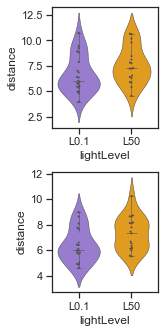

In [133]:
import seaborn as sns
f, ax = plt.subplots(2,1, figsize = (w,h))

i=0
for v, sub in Dist_df.groupby('visit'):
    sns.violinplot(x='lightLevel', y='distance', data = sub, 
                   inner = None, 
                   palette=['mediumpurple','orange'], 
                   linewidth = 0.5,
                   ax=ax[i])
    sns.boxplot(x='lightLevel', y='distance', data = sub, 
                width = 0.2,
                linewidth = 0.5,
                fliersize = 0,
                ax=ax[i])
    sns.swarmplot(x='lightLevel', y='distance', data = sub,
                size=2, 
                  color="0.3",
                  linewidth=0,
                  ax=ax[i])

#     plt.ylim(-1.5,15)
#     ax.xaxis.grid(False)
#     plt.yticks(size = 8)
#     plt.xticks([0,1], size = 8)
#     plt.xlabel('Light Level', size = 8)
#     plt.ylabel('Distance From Nectary (cm)', size = 8)
#     sns.despine(trim=True, left=True)
    i+=1
plt.tight_layout()
plt.savefig('./dataFolders/Output/KinematicAnalysis_v5/Figures/distance.pdf')

In [118]:
low_first = Dist_df[(Dist_df.lightLevel == 'L0.1') & (Dist_df.visit == 'first')].distance.values
high_first = Dist_df[(Dist_df.lightLevel == 'L50') & (Dist_df.visit == 'first')].distance.values

low_last = Dist_df[(Dist_df.lightLevel == 'L0.1') & (Dist_df.visit == 'last')].distance.values
high_last = Dist_df[(Dist_df.lightLevel == 'L50') & (Dist_df.visit == 'last')].distance.values

In [135]:
from scipy import stats

stats.mannwhitneyu(low_first, high_first)

MannwhitneyuResult(statistic=130.0, pvalue=0.04967112392673264)

In [136]:
stats.mannwhitneyu(low_last, high_last)

MannwhitneyuResult(statistic=94.0, pvalue=0.016355791764910223)